# Hardware Optimization of Quantum Violations of the CHSH Inquality

This notebook aggregates and plots data from CHSH optimizations on quantum hardware. Data is analyzed for the following data collection scripts:
* `./script/ibm_belem_simple_chsh_opt_parameter_shift.py`
* `./script/ibm_belem_simple_chsh_opt_natural_gradient.py`

In [2]:
from context import QNetOptimizer as QNopt
import matplotlib.pyplot as plt
from pennylane import numpy as np

The data from all of our hardware optimizations is imported from file. 

In [3]:
from os import listdir
from os.path import isfile, join
import re

data_path_nat_grad = "../../script/data/ibm_belem_simple_chsh_opt_natural_gradient/"
data_files_nat_grad = [
    join(data_path_nat_grad, f) for f in listdir(data_path_nat_grad) if (
        isfile(join(data_path_nat_grad, f)) and f.endswith(".json")
    )
]
nat_grad_opt_dicts = [QNopt.read_optimization_json(file) for file in data_files_nat_grad]
print("num natural gradient optimizations : ", len(data_files_nat_grad))

data_path_param_shift = "../../script/data/ibm_belem_simple_chsh_opt_parameter_shift/"
data_files_param_shift = [
    join(data_path_param_shift, f) for f in listdir(data_path_param_shift) if (
        isfile(join(data_path_param_shift, f)) and f.endswith(".json")
    )
]
param_shift_opt_dicts = [QNopt.read_optimization_json(file) for file in data_files_param_shift]
print("num parameter shift optimizations : ", len(data_files_param_shift))

num natural gradient optimizations :  11
num parameter shift optimizations :  11


We compute the mean and standard error across for each iteration across all hardware runs.

In [4]:
def scores_mean_stderr(opt_dicts):
    scores_array = np.array([opt_dict["scores"][0:16] for opt_dict in opt_dicts])    
    settings_array = [opt_dict["settings_history"][0:16] for opt_dict in opt_dicts]
    theoretical_max_array = np.array([opt_dict["theoretical_score"] for opt_dict in opt_dicts])
    mean_theoretical_score = np.mean(theoretical_max_array)

    scores_mean = np.mean(scores_array, axis=0)   
    scores_stderr = np.std(scores_array, axis=0, ddof=1) / np.sqrt(scores_array.shape[1])
    scores_max = np.max(scores_array, axis=0)
    max_ids = np.argmax(scores_array, axis=0)
    max_settings = [
        settings_array[max_ids[i]][i] for i in range(16) 
    ]

    return (scores_max, scores_mean, scores_stderr, max_settings, mean_theoretical_score)

In [5]:
prep_nodes = [QNopt.PrepareNode(1,[0,1],QNopt.ghz_state, 0)]
meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(2, 2, [1], QNopt.local_RY, 1),
]

chsh_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes)
chsh_cost = QNopt.chsh_inequality_cost(chsh_ansatz)

## Visualization

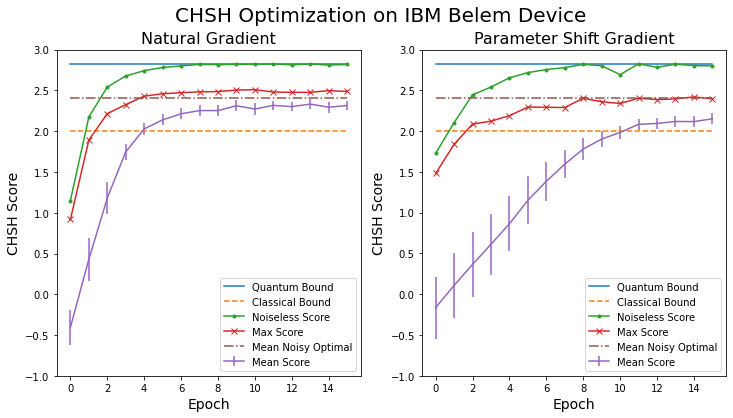

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
yticks = [-1,-.5,0,0.5,1,1.5,2,2.5,3]

(
    nat_grad_max,
    nat_grad_mean,
    nat_grad_err,
    nat_grad_max_settings,
    nat_grad_mean_theory_score,
) = scores_mean_stderr(nat_grad_opt_dicts)
nat_grad_ideal_scores = [
    -(chsh_cost(nat_grad_max_settings[i])) for i in range(16)
]

(
    param_shift_max,
    param_shift_mean,
    param_shift_err,
    param_shift_max_settings,
    param_shift_mean_theory_score,
) = scores_mean_stderr(param_shift_opt_dicts)
param_shift_ideal_scores = [
    -(chsh_cost(param_shift_max_settings[i])) for i in range(16)
]

avg_chsh_score = (nat_grad_mean_theory_score + param_shift_mean_theory_score)/2

ax1.plot(range(16), [2*np.sqrt(2)]*16, "-", label="Quantum Bound")
ax1.plot(range(16), [2]*16, "--", label="Classical Bound")
ax1.plot(range(16), nat_grad_ideal_scores, marker=".", label="Noiseless Score")
ax1.plot(range(16), nat_grad_max, marker="x" , label="Max Score")
ax1.errorbar(range(16), nat_grad_mean, nat_grad_err, label="Mean Score")
ax1.plot(range(16), [avg_chsh_score]*16, "-.", label="Mean Noisy Optimal")

ax1.set_title("Natural Gradient", size=16)
ax1.set_xlabel("Epoch", size=14)
ax1.set_ylabel("CHSH Score", size=14)
ax1.set_yticks(yticks)
ax1.legend()

ax2.plot(range(16), [2*np.sqrt(2)]*16, "-", label="Quantum Bound")
ax2.plot(range(16), [2]*16, "--", label="Classical Bound")
ax2.plot(range(16), param_shift_ideal_scores, marker=".", label="Noiseless Score")
ax2.plot(range(16), param_shift_max, marker="x" , label="Max Score")
ax2.errorbar(range(16), param_shift_mean, param_shift_err, label="Mean Score")
ax2.plot(range(16), [avg_chsh_score]*16, "-.", label="Mean Noisy Optimal")

ax2.set_title("Parameter Shift Gradient", size=16)
ax2.set_xlabel("Epoch", size=14)
ax2.set_ylabel("CHSH Score", size=14)
ax2.set_yticks(yticks)
ax2.legend(loc="lower right")

fig.suptitle("CHSH Optimization on IBM Belem Device\n", size=20)
plt.show()

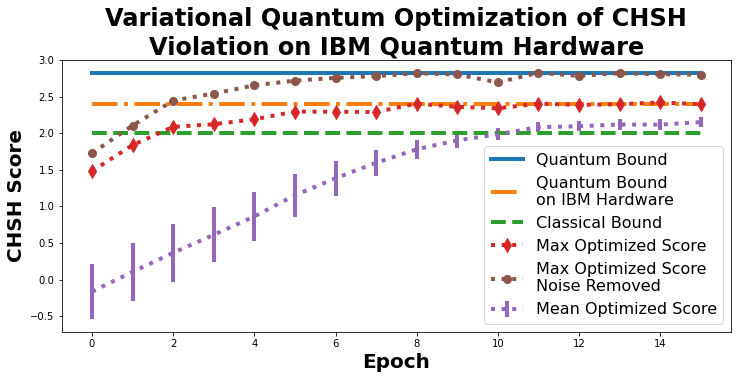

In [56]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,5))
yticks = [-.5,0,0.5,1,1.5,2,2.5,3]

(
    param_shift_max,
    param_shift_mean,
    param_shift_err,
    param_shift_max_settings,
    param_shift_mean_theory_score,
) = scores_mean_stderr(param_shift_opt_dicts)
param_shift_ideal_scores = [
    -(chsh_cost(param_shift_max_settings[i])) for i in range(16)
]

avg_chsh_score = (nat_grad_mean_theory_score + param_shift_mean_theory_score)/2

ax1.plot(range(16), [2*np.sqrt(2)]*16, "-", linewidth=4, markersize=8, label="Quantum Bound")
ax1.plot(range(16), [avg_chsh_score]*16, "-.", linewidth=4, markersize=8, label="Quantum Bound\non IBM Hardware")

ax1.plot(range(16), [2]*16, "--", linewidth=4, markersize=8, label="Classical Bound")
ax1.plot(range(16), param_shift_max, ":d", linewidth=4, markersize=10, label="Max Optimized Score")
ax1.errorbar(range(16), param_shift_mean, param_shift_err, linestyle=":", linewidth=4, markersize=8, label="Mean Optimized Score")
ax1.plot(range(16), param_shift_ideal_scores, ":.", linewidth=4, markersize=16, label="Max Optimized Score\nNoise Removed")


ax1.set_title("Variational Quantum Optimization of CHSH\nViolation on IBM Quantum Hardware", size=24,fontweight="bold")
ax1.set_xlabel("Epoch", size=20, fontweight="bold")
ax1.set_ylabel("CHSH Score", size=20, fontweight="bold")
ax1.set_yticks(yticks)
ax1.legend(loc="lower right",fontsize=16)

plt.show()